# Describing the Combined Files and Defining Research Questions
#### Jameson Carter, Mihir Bhaskar, Abhilash Biswas
#### 11/26/2021
The following code evaluates a joined file created in CombineData.ipynb. This file contains ACS tracts in Chicago and demographic information, complaints made against police officers in those locations, and geographic information about the city of chicago, within those tracts. 

In this file, we-

 - Provide some initial visualizations that describe this dataset.
 - Define some of our prediction variables, alongside some of our research questions.
 - Run a preliminary test

## Describe the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt
from pyprojroot import here
import seaborn as sns
%matplotlib inline

import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 

In [2]:
data = pd.read_csv(here('./data/Combined.csv'))

### Evaluating the Target Variable- Complaints

Text(0.5, 1.0, 'Complaints in Chicago')

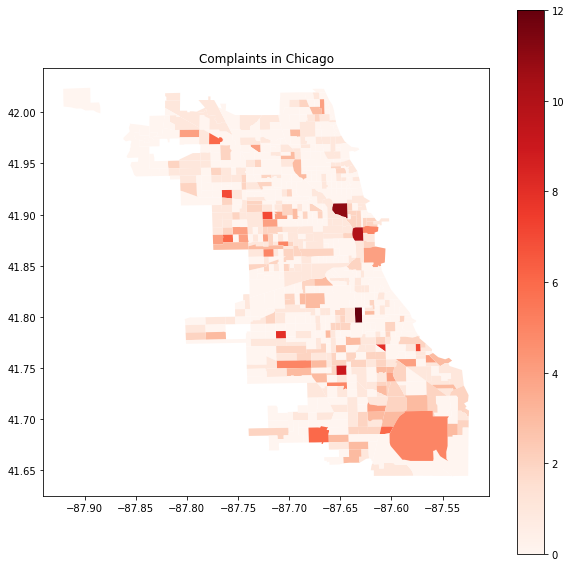

In [3]:
data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])
plt.rcParams['figure.figsize'] = [10, 10]
GeoData = gpd.GeoDataFrame(data, geometry='geometry')
GeoData.plot("complaint_count", cmap = "Reds", legend = True)
plt.title('Complaints in Chicago')

The above plot shows that there are a few tracts where complaints are quite high, although there is not a clear geographic relationship. There seem to be higher numbers of complaints on the South Side of the city. 

The plot flags a few tracts as having particularly high complaint incididence:
 - Tract 8356 (12), which is a small tract nestled between a large highway and a railyard on the South side, with a police station nearby.
 - Tract 8422 (11), which is a larger tract containing Goose Island, an island bounded by a canal and a river near a historically poor neighborhood called Cabrini-Green.
 - Tract 1839 (10), is a larger tract nestled between the Chicago River and Lake Michigan, and is nearby the Art Institute of Chicago.
 
I evaluated these tracts using the following https://www.chicagocityscape.com/maps/?place=censustract-17031835600

In [4]:
GeoData.sort_values('complaint_count', ascending = False).head(3)

,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0022PE,...,GEOID10,complaint_count,police_stations,fire_stations,public_schools,parks,commercial_establishments,number_of_police_killings,total_crimes_reported,inv_stop_count
728,1400000US17031835600,896.0,16.5,3.5,39.8,40.2,14.4,60.2,2.08,20.3,...,17031835600,12.0,1.0,0.0,0.0,1.0,43.0,0.0,2065,35.0
781,1400000US17031842200,3362.0,18.2,9.6,36.8,35.4,10.0,18.5,1.62,9.8,...,17031842200,11.0,1.0,0.0,3.0,1.0,253.0,0.0,5352,80.0
755,1400000US17031839100,7545.0,22.9,8.6,42.6,25.8,4.7,5.2,1.61,6.5,...,17031839100,10.0,0.0,1.0,0.0,0.0,2065.0,0.0,21418,47.0


The following exploration finds that the typical tract (as defined by the median), exhibits no complaints, while the average tract exhibits 0.83 complaints.

In [5]:
GeoData[['complaint_count']].describe()

,complaint_count
count,798.000000
mean,0.810777
std,1.383913
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,12.000000


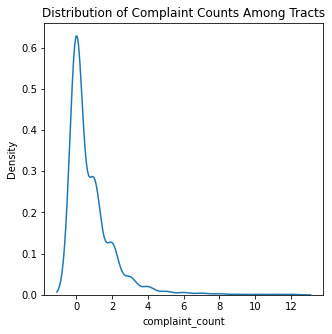

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(GeoData['complaint_count'])
plt.title('Distribution of Complaint Counts Among Tracts')
plt.show()

### Evaluating relationships between variables

The code below creates a correlation matrix for the dataset, and filters it to those variables with the absolute value of correlation greater than 80% (since there are too many variables to visualize in a complete correlation matrix).

In [7]:
# Moving the target variables so they are at the front of the dataset
target = GeoData.pop('complaint_count')
GeoData.insert(loc=0, column='complaint_count', value=target)

# Generating a correlation matrix
# Note: code below sourced from this link: https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
corr = GeoData.corr()

# This code keeps only the upper triangle of the correlation matrix (because the two triangles are copies/repeats)
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

# This reshapes the matrix to become like a stack, with Var 1, Var 2, and their respective score
corr_triu = corr_triu.stack()

# Making the output more readable
corr_triu.name = 'Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']

# Filtering only those values where absolute value of the correlation is > 80% (i.e. highly correlated variables)
corr_triu = corr_triu[abs(corr_triu) > 0.8].to_frame()

# Ordering from highest correlation to lowest based on absolute correlation
corr_triu.sort_values(by='Correlation Coefficient', key=pd.Series.abs, ascending=False, inplace=True)


#corr_triu.sort_values(by=['Correlation Coefficient'], inplace=True)

print(f'Number of feature pairs that are highly correlated (i.e. >80%): {len(corr_triu)}')

corr_triu


Number of feature pairs that are highly correlated (i.e. >80%): 28


,,Correlation Coefficient
Col1,Col2,
DP02_0015PE,DP03_0066PE,0.940157
DP03_0004PE,DP03_0013PE,0.925954
DP05_0037PE,DP05_0038PE,-0.923312
DP02_0093PE,DP02_0114PE,0.917271
DP03_0074PE,DP03_0098PE,0.896063
DP02_0014PE,DP05_0019PE,0.886578
DP02_0065PE,DP03_0027PE,0.885356
DP02_0022PE,DP05_0019PE,0.876638
DP02_0072PE,DP02_0076PE,0.875655


There are several feature pairs, predominantly from the ACS data, that are highly correlated - 28 feature pairs have an absolute correlation coefficient greater than 80%. Some of these variables will need to be dropped based on some other criterion before any modelling efforts.

Some of the other pairs that are highly correlated are:
- % of households with social security and households with a member 65+.
- % of population that is employed and % of women who are employed.
- % of population that is white and % of population that is black.
- % of population born abroad and % of population who do not speak English at home, and who do not speak English 'very well.'

Several of these variables will need to be dropped in the modelling effort through selection methods and cleaning. Some are near-mirrors as they account for similar elements to the same issue. 

**The code below now looks at spatial distributions of a few predictors**, to see if there are any geographic patterns

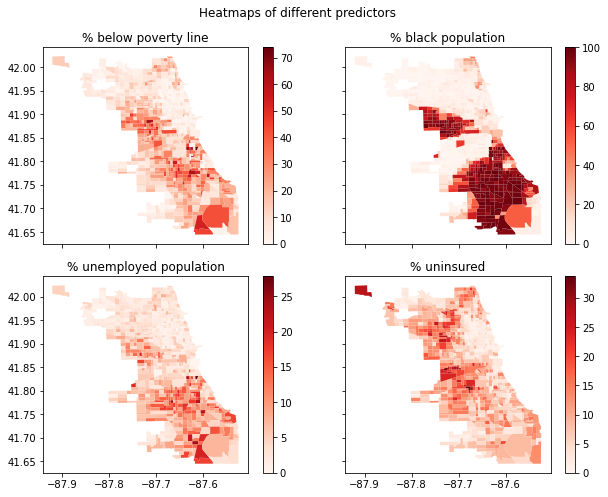

In [8]:
# Variables to create plots for in a loop
variables = ['DP03_0119PE', 'DP05_0038PE', 'DP03_0005PE', 'DP03_0099PE']
titles = ['% below poverty line', '% black population', '% unemployed population', '% uninsured']

# Set up the subplots in a 2x2 grid and initialise the figure
fig, axes = plt.subplots(2,2, figsize=(9,7), sharex=True, sharey=True)
fig.suptitle('Heatmaps of different predictors')

# Loop through both the degree (range from 1-7), and the tile we want the plot in (from the axes)
i = -1
for var, ax in zip(variables, axes.flatten()):
    
    # Create heatmap plot
    GeoData.plot(var, cmap='Reds', legend=True, ax=ax)
    
    # Give it a title according to the titles list
    i += 1
    ax.set_title('{:s}'.format(titles[i]))

plt.tight_layout()

The plots show:
- A concentration of tracts with a high % of black families and individuals in the south side of the city
- Individuals below the poverty line, and unemployment rates follow a very similar geographic pattern, and are also starker towards the center and south sides of the city
- It is harder to discern a clear pattern in health insurance, although it appears that the largest incidence of uninsurance are in the segments of the city where non-white populations live, as well as a significant population of people without insurance in the whiter areas of the city.

These plots seem to suggest that there are groupings of tracts that share similar characteristics. This informs our third research question, of wanting to explore unsupervised learning to uncover naturally occuring clusters of tracts based on their characteristics.

## Research Question 1

#### Predicting the use of force complaint rate in Chicago Census tracts

###### Why: Evaluate which tracts may have a high complaint rate and direct policy attention towards those tracts

### Preliminary prediction model - Checking the prediction accuracy and generalisibility of a linear model containing all possible predictors in the dataset (kitchen sink prediction model)




In [9]:
#Creating X and y dataframes
df_y = GeoData['complaint_count']

# Remove target variable, perfectly correlated variables and some other highly correlated vars mentioned above
# Additionally, remove complaint count, variable used to create complaint rate
df_X = GeoData.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 

df_X = df_X.select_dtypes(['number']) 

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X,df_y,test_size = 0.20, random_state = 11)                                                      
                                                                                        
#Fitting model
lm_r1 = LinearRegression()
lm_r1.fit(X_train, y_train)

#Calculating MSE
MSE_train  = mean_squared_error(y_train, lm_r1.predict(X_train))
print("Training R-squared: ", lm_r1.score(X_train, y_train))
print("MSE train: " , MSE_train)

MSE_test  = mean_squared_error(y_test, lm_r1.predict(X_test))
print("Testing R-squared: ", lm_r1.score(X_test, y_test))
print("MSE test: " , MSE_test)

Training R-squared:  0.5275582540234077
MSE train:  0.8567530337871174
Testing R-squared:  0.35876168437116507
MSE test:  1.4787556719321837


Commentary: We have a likely overfitted model, but it's useful to see how well the model is fitting from this kitchen sink linear regression. 

The training R squared is ~53%, however the testing R squared drops to 36%. This is a signal of overfitting. 
By and large, for this exploratory exercise, the key takeaway is that in the training set at least, the predictors are able to explain 53% of the variation in the training set. This is a bad performance, as far as we can tell.

## Research Question 2

### Classifying the use of force complaint rate in Chicago census tracts

##### Why: As compared to a prediction model, evaluate whether we can better predict whether a tract would have any use of force complaints or not as compared to predicting the exact complaint rate. This would still have the same implication of directing policy attention towards tracts where we expect some use of force complaints to happen

### Preliminary classification model - Checking whether a kitchen sink classification model performs better than a prediction model. 

We will classify complaint rate into Any complaints (1) and no complaints (0)

In [23]:
#Creating the first classification
GeoData['any_complaints'] = np.where(GeoData['complaint_count']>0, 1, 0)


              precision    recall  f1-score   support

           0      0.711     0.711     0.711        97
           1      0.556     0.556     0.556        63

    accuracy                          0.650       160
   macro avg      0.633     0.633     0.633       160
weighted avg      0.650     0.650     0.650       160



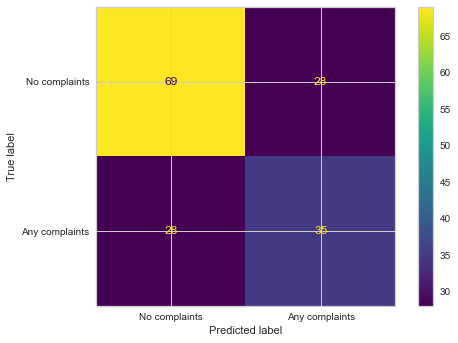

In [24]:
#Creating the classification model (1)

#Creating X and y dataframes
df_y = GeoData['any_complaints']
df_X = GeoData.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 
df_X = df_X.select_dtypes(['number']) 



#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X,df_y,test_size = 0.20, random_state = 11)                                                      

#Importing class
from sklearn.naive_bayes import GaussianNB

#Defining model
model = GaussianNB()
nb_pred = model.fit(X_train,y_train).predict(X_test) 
print(classification_report(y_test,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test,nb_pred) 
target_names = ['No complaints','Any complaints']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

                                                                                        


Commentary: We see that a Naive Bayesian classification model has quite low accuracy in predicting whether a tract has any complaints or not. This is an initial indication that our model may be affected by irrelevant variables and hence we should apply subsetting methods to keep only a subset of the full predictor list. 

## Research Question 3

### a) Can we effectively cluster census tracts into groups having similar characteristics (unsupervised learning)
### b) Do census tracts in a given cluster have similar outcomes in terms of use of force complaints

#### This analysis would allow us to evaluate whether tracts that have similar outcomes (from b) also have similar characteristics. 

##### NOTE: We will explore and analyse this research question as a part of our final submission

In [13]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer

In [14]:
df_y = GeoData['complaint_count']
df_X = GeoData.drop(columns = ['complaint_count',
                               'GEOID10', 'geo_id', 'geometry']) 
df_X = df_X.select_dtypes(['number']) 

Next, we need to determine the optimal number of K for our clustering model. For this preliminary exploration, we will only use this method to choose K, but will take a more extensive approach in the future. This approach finds that the optimal K is equal to 5.

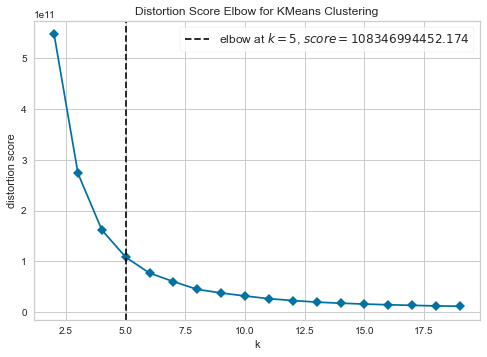

In [15]:
#Create a Kmeans model
model = KMeans(random_state=1)
#run from k=2 to k=20
visualizer = KElbowVisualizer(model, k=(2,20), timings = False).fit(df_X)
visualizer.show(); 

It looks like our clusters are not properly separated, as there is overlap between the clusters at k = 5.

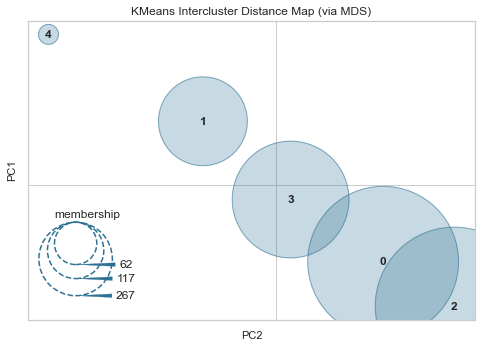

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [19]:
tunedmod = KMeans(random_state=1, n_clusters=5).fit(df_X)
visualizer = InterclusterDistance(tunedmod).fit(df_X)
visualizer.show()  

The following plot shows that two clusters, cluster 1 and 4 are quite small (the two clusters that were most seperable from the above plot). This is not necessarily a good thing, although all silhouette coefficients are greater than average and closer to 1 than 0, which is a better sign.

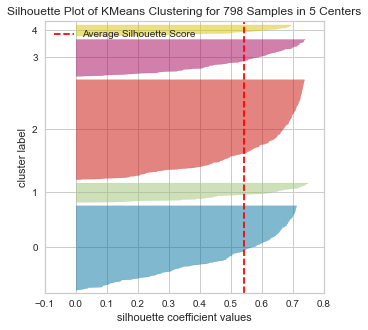

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 798 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [215]:
visualizer = SilhouetteVisualizer(tunedmod, colors='yellowbrick').fit(df_X)
visualizer.show()

Now that we have our K means model, lets evaluate the qualities of our response variable, as well as of a few variables of interest to see how clusters correlate to those respective variables.

In [20]:
pred = tunedmod.predict(df_X)
GeoData['cluster_label'] = pd.Series(pred, index=df_X.index)

In [34]:
print('Complaint Count by cluster:\n',GeoData.groupby('cluster_label').describe()['complaint_count'])
print('\nPolice stops by cluster:\n', GeoData.groupby('cluster_label').describe()['inv_stop_count'])
print('\nPercentage in Poverty by cluster:\n', GeoData.groupby('cluster_label').describe()['DP03_0119PE'])

Complaint Count by cluster:
                count      mean       std  min  25%  50%  75%   max
cluster_label                                                     
0              267.0  0.670412  1.164959  0.0  0.0  0.0  1.0   8.0
1               62.0  0.806452  1.576869  0.0  0.0  0.0  1.0  10.0
2              316.0  1.101266  1.586410  0.0  0.0  1.0  2.0  12.0
3              117.0  0.495726  1.164296  0.0  0.0  0.0  1.0  11.0
4               36.0  0.333333  0.585540  0.0  0.0  0.0  1.0   2.0

Police stops by cluster:
                count       mean        std   min    25%   50%    75%   max
cluster_label                                                             
0              267.0  33.209738  12.706380   1.0  26.00  34.0  40.00  77.0
1               62.0  38.032258  14.499257   6.0  29.50  35.5  49.00  77.0
2              316.0  31.920886  12.553254   3.0  24.00  30.0  38.25  86.0
3              117.0  34.299145  14.946609   6.0  25.00  34.0  43.00  80.0
4               36.0  39.

From the above exploration, it appears that complaint counts vary on average by a somewhat small amount (from 0.3 to 1.1), as do police stops (from 31.9 to 39.1), although poverty varies widely. Cluster 2 at the mean showed a 27% poverty rate at the average, while clusters 4, 1, and 3 exhibited average poverty rates of 5% or less. 

## Sources

 - https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
 - The in class exercise Clustering-Mini2_JamsonCarter.ipynb
 - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
 - https://stackoverflow.com/questions/38372188/how-to-add-k-means-predicted-clusters-in-a-column-to-a-dataframe-in-python
 - https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
 - https://stackoverflow.com/questions/33575587/pandas-dataframe-how-to-apply-describe-to-each-group-and-add-to-new-columns